<a href="https://colab.research.google.com/github/ZZongSeung/stock-prediction/blob/main/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA를 활용한 예측(단변량)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch
import warnings
warnings.filterwarnings("ignore")

# 데이터 분석 시퀀스

0. data import
1. EDA(계절적인 요소?)
2. many to one data algorithm
3. make the LSTM algorithm
4. make the train_loop / test_loop  

In [2]:
df = pd.read_csv("/content/bitcoin.csv")
# 일자 datetime생성2018-11-24 00:00:00
import datetime as dt
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = "%Y-%m-%d %H:%M:%S")
df.set_index('Timestamp', inplace=True)

# ARIMA

In [3]:
!pip install pmdarima

In [4]:
from statsmodels.tsa.stattools import adfuller # 단위근 검정이 가능
from statsmodels.tsa.arima_model import ARIMA #ARIMA Model 생성
import statsmodels.api as sm # 통계 모듈 생서
import pmdarima as pm   # auto_arima 생성이 가능함
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf / pacf그래프
import scipy as scs
from scipy.stats import norm
from pmdarima.arima import ndiffs

In [5]:
df

,market-price
Timestamp,
2018-11-24,4352.98
2018-11-25,3862.01
2018-11-26,4010.72
2018-11-27,3793.35
2018-11-28,3828.45
...,...
2021-11-19,56921.34
2021-11-20,58133.02
2021-11-21,59777.98


1


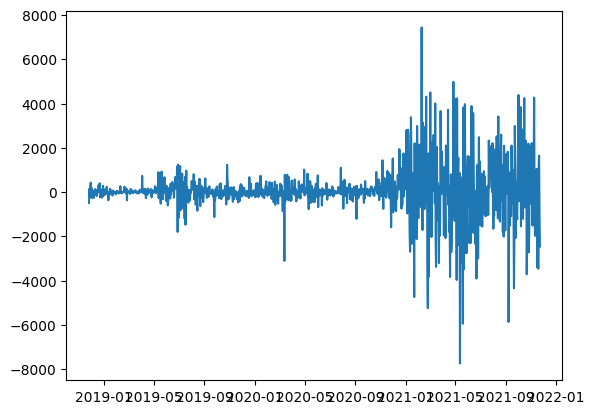

In [6]:
plt.plot(df.diff().dropna()) # white noise 생성 -> 1차분이 맞다고 확인
print(ndiffs(df)) # 차분 1로 확인

In [7]:
 # adffuler
class ts_test:

  @staticmethod
  def acf_pacf(data):

    row=2; col=1
    fig, axs = plt.subplots(row,col, figsize=(16,10))
    plot_acf(data ,ax=axs[0])
    plot_pacf(data, ax=axs[1])
    plt.tight_layout()


  @staticmethod
  def adf_test(data):
    statistic, pvalue, lag, number_data, critical, _ = adfuller(data)
    print(statistic)
    print(pvalue)
    print(lag)
    print(number_data)

    for i,v in critical.items(): # i : 신뢰구간/ v:
      print(f"critical_value :  {i} : {v}")

    print("\n")
    print("pvalue 검정결과")
    try:
      if pvalue > 0.05:
        raise Exception("값이 0.05보다 큽니다.")
      else:
        print("p-value값이 0.05보다 작습니다.")

    except Exception as e:
      print("차분이 팔요합니다,",e)

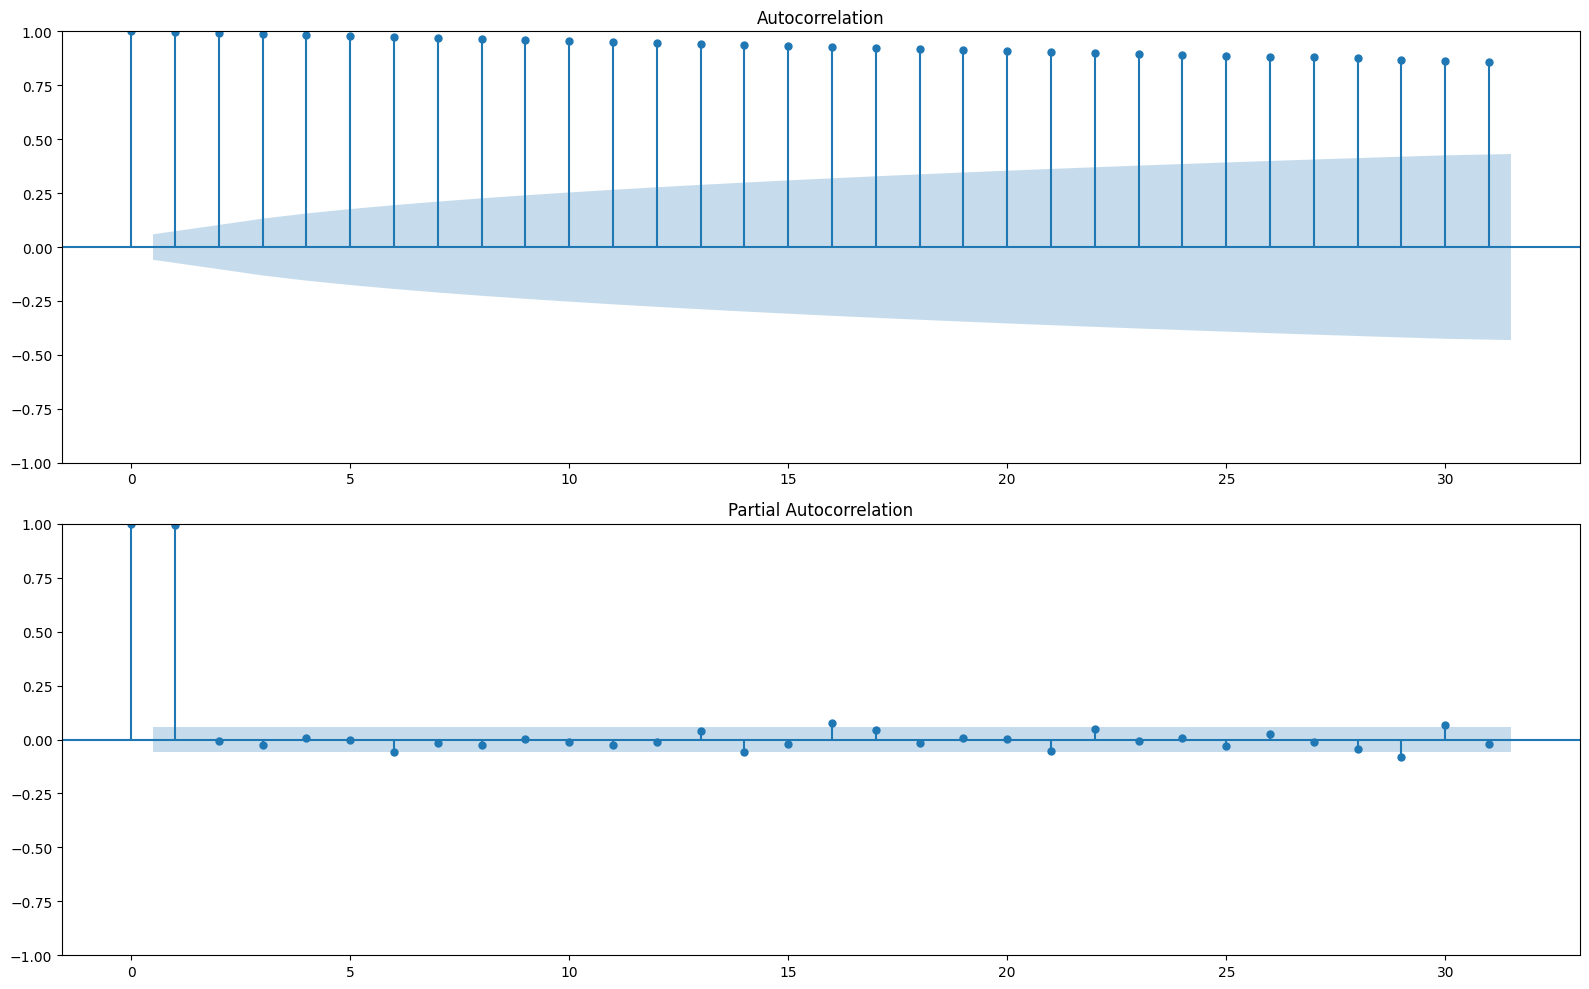

In [8]:
ts_test.acf_pacf(df)# 자기상관은 문제가 있음 / 부분자기상관은 2에서 떨어짐

In [9]:
ts_test.adf_test(df)

-0.2718516334036858
0.9293974533997902
20
1075
critical_value :  1% : -3.4364476591811033
critical_value :  5% : -2.864232347211692
critical_value :  10% : -2.5682035004867494


pvalue 검정결과
차분이 팔요합니다, 값이 0.05보다 큽니다.


None
-7.204038610414291
2.3251999442829804e-10
19
1075
critical_value :  1% : -3.4364476591811033
critical_value :  5% : -2.864232347211692
critical_value :  10% : -2.5682035004867494


pvalue 검정결과
p-value값이 0.05보다 작습니다.
None


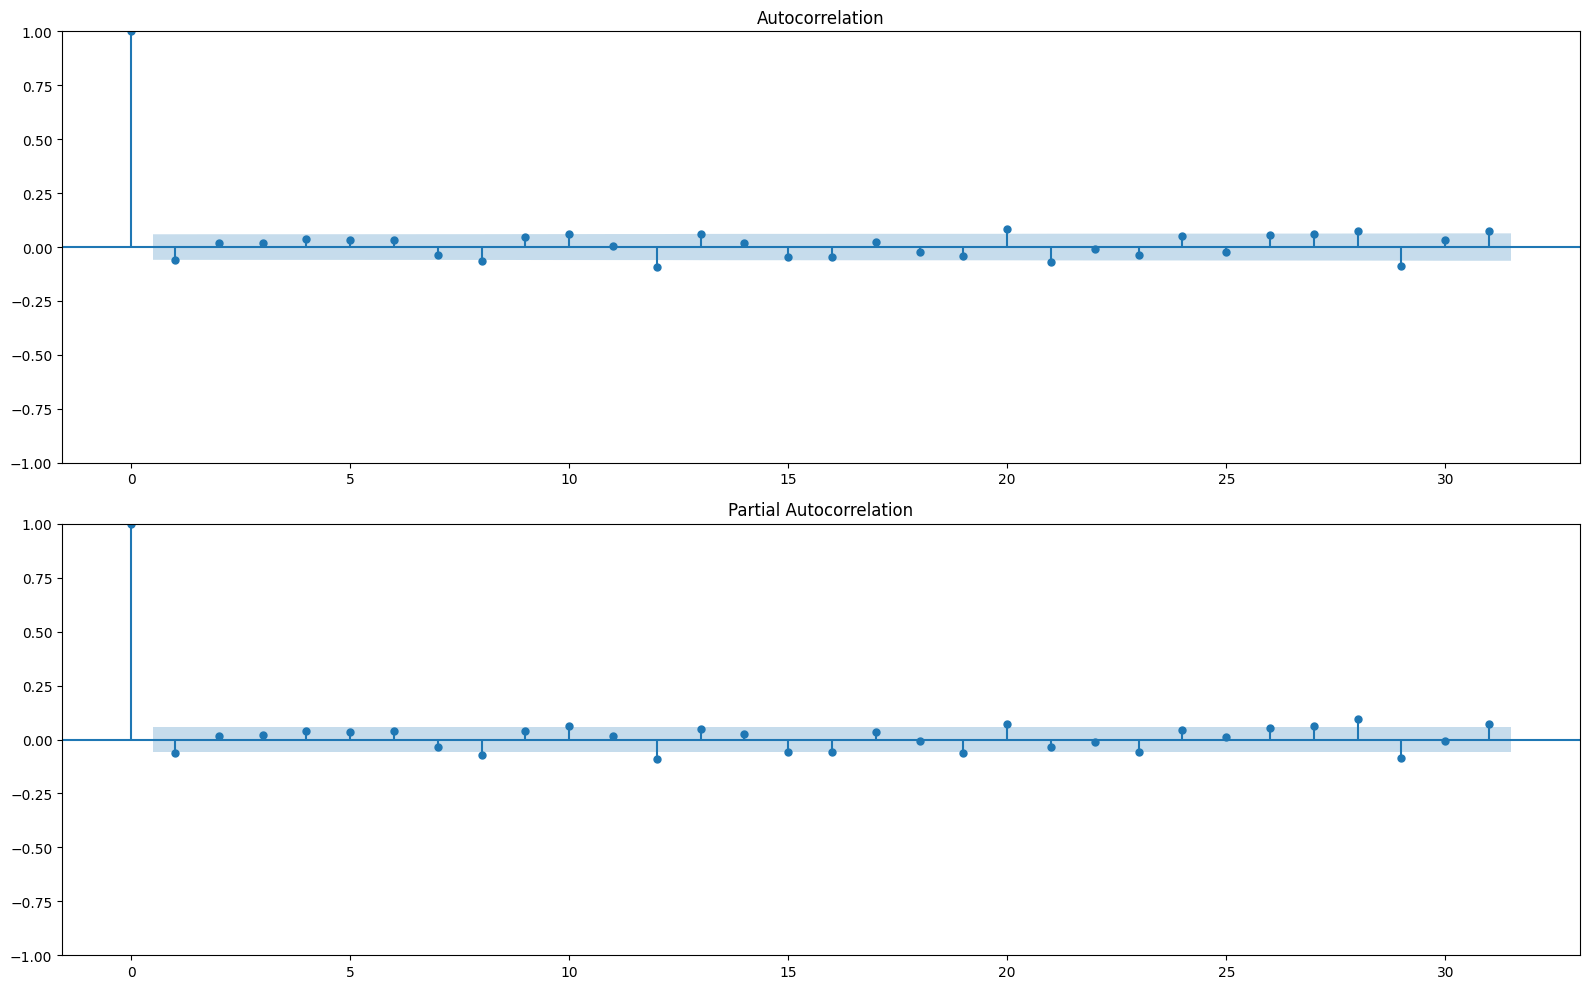

In [10]:
# 차분 실시
ts_diff = df.diff()

# 그래프
print(ts_test.acf_pacf(ts_diff.dropna())) # AR : 1~2 / MA : 1~2

# 검정 실시
print(ts_test.adf_test(ts_diff.dropna())) # 차분은 1정도로 생성

# 모형 - 원데이터 : ARIMA(1,1,1)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(2, 1,2))
fit_data = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market-price   No. Observations:                 1096
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9221.430
Date:                Thu, 22 Aug 2024   AIC                          18452.861
Time:                        09:04:29   BIC                          18477.853
Sample:                    11-24-2018   HQIC                         18462.318
                         - 11-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2962      0.019     67.204      0.000       1.258       1.334
ar.L2         -0.9093      0.018    -49.396      0.000      -0.945      -0.873
ma.L1         -1.3340      0.013   -104.597      0.0

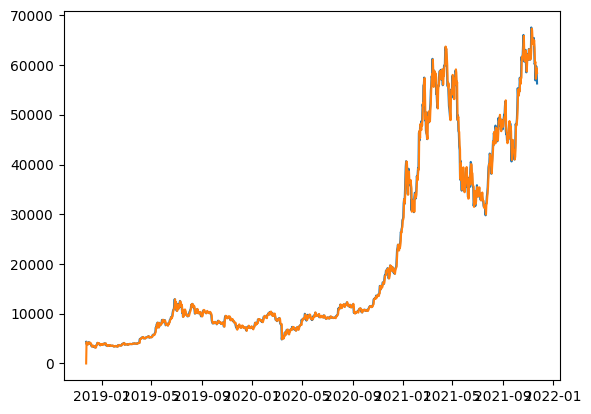

In [12]:
print(fit_data.summary())

#
import datetime as dt

start_index = dt.datetime(2018, 11, 24) #b 2021-11-23
end_index = dt.datetime(2021, 11, 23)

forecast = fit_data.predict(start=start_index, end=end_index)

print("====================")
plt.plot(df, label= "real")
plt.plot(forecast, label="pred")

In [13]:
# mape 계산
def mape(real, pred):

  result =  np.mean(np.abs((real-pred)/real))*100
  return np.round(result,2)

In [14]:
mape(df["market-price"], df["pred"]) #2.89

KeyError: 'pred'

In [15]:
df["pred"] = forecast

df.rename(columns = {
      "market-price":"real",
      "pred":"pred"
})
print(df[1:])

result = df[1:] # 행 오류

            market-price          pred
Timestamp                             
2018-11-25       3862.01   4289.281437
2018-11-26       4010.72   3884.290839
2018-11-27       3793.35   4077.503387
2018-11-28       3828.45   3872.289100
2018-11-29       4256.55   3859.939705
...                  ...           ...
2021-11-19      56921.34  60646.727416
2021-11-20      58133.02  57241.014295
2021-11-21      59777.98  58064.979925
2021-11-22      58755.90  59383.935234
2021-11-23      56301.52  58426.118888

[1095 rows x 2 columns]


In [16]:
# auto_arima로 설정df

In [17]:
df1=df.iloc[:,0]

In [18]:
df1

,market-price
Timestamp,
2018-11-24,4352.98
2018-11-25,3862.01
2018-11-26,4010.72
2018-11-27,3793.35
2018-11-28,3828.45
...,...
2021-11-19,56921.34
2021-11-20,58133.02
2021-11-21,59777.98


In [19]:
# train - val data 확인 후 예측 실시
split = int(len(df1)*0.7)

train_data = df1[:split]
test_data = df1[split:]

<Axes: xlabel='Timestamp'>

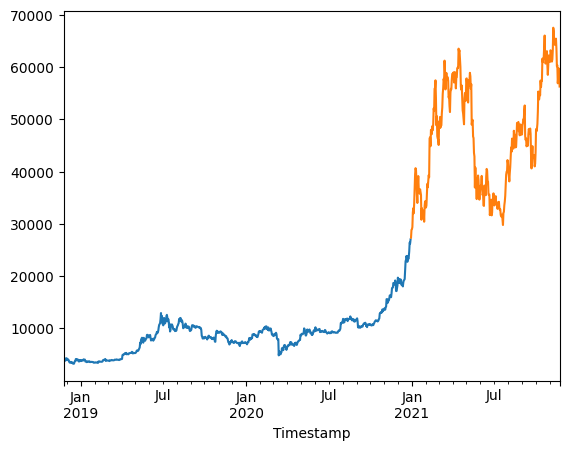

In [20]:
train_data.plot()
test_data.plot() # train - test split

```
!pip install pmdarima
from pmdarima.arima import auto_arima

model = pm.auto_arima(y = train_data       # 데이터
                      , d = 1           # (d)차분 차수 (기본값 = none), 지정하지 않으면 실행 기간이 매우 길어질 수 있음
                      , start_p = 0     # (p)탐색 시초값 (기본값 = 2)
                      , max_p = 3       # (기본값 = 5)
                      , start_q = 0     # (q)탐색 시초값 (기본값 = 2)
                      , max_q = 3       # (기본값 = 5)
                      , m = 1           # (기본값 = 1)
                      , seasonal = False # 기본값 = True, 계절변동 ARIMA(SARIMA)에 해당시 True로 수정
                      , stepwise = True
                      , trace=True      # stepwise로 모델을 적합할 때마다 결과를 프린트
                      )
```

In [21]:
arima_model = pm.auto_arima(train_data,
                            df=1,
                            m=1,
                            alpha=0.05,
                            stepwise=True,
                            trace=True,
                            seasonal=False) # (1,2,1)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11784.784, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11519.448, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11782.794, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11415.169, Time=0.61 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11363.615, Time=0.67 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=11334.596, Time=0.70 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=11323.439, Time=0.96 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=11215.510, Time=6.13 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=11213.492, Time=3.33 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11211.956, Time=5.56 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11209.580, Time=1.66 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11207.582, Time=1.13 sec
 ARIMA(1,2,2)(0,0,0)[0] interc

In [22]:
ts_test.adf_test(train_data.diff().dropna()) # 1차분결과 잔차는 백색소음을 가지고 있음.

-4.41657214849194
0.00027741605499769146
20
745
critical_value :  1% : -3.4391580196774494
critical_value :  5% : -2.8654273226340554
critical_value :  10% : -2.5688400274762397


pvalue 검정결과
p-value값이 0.05보다 작습니다.


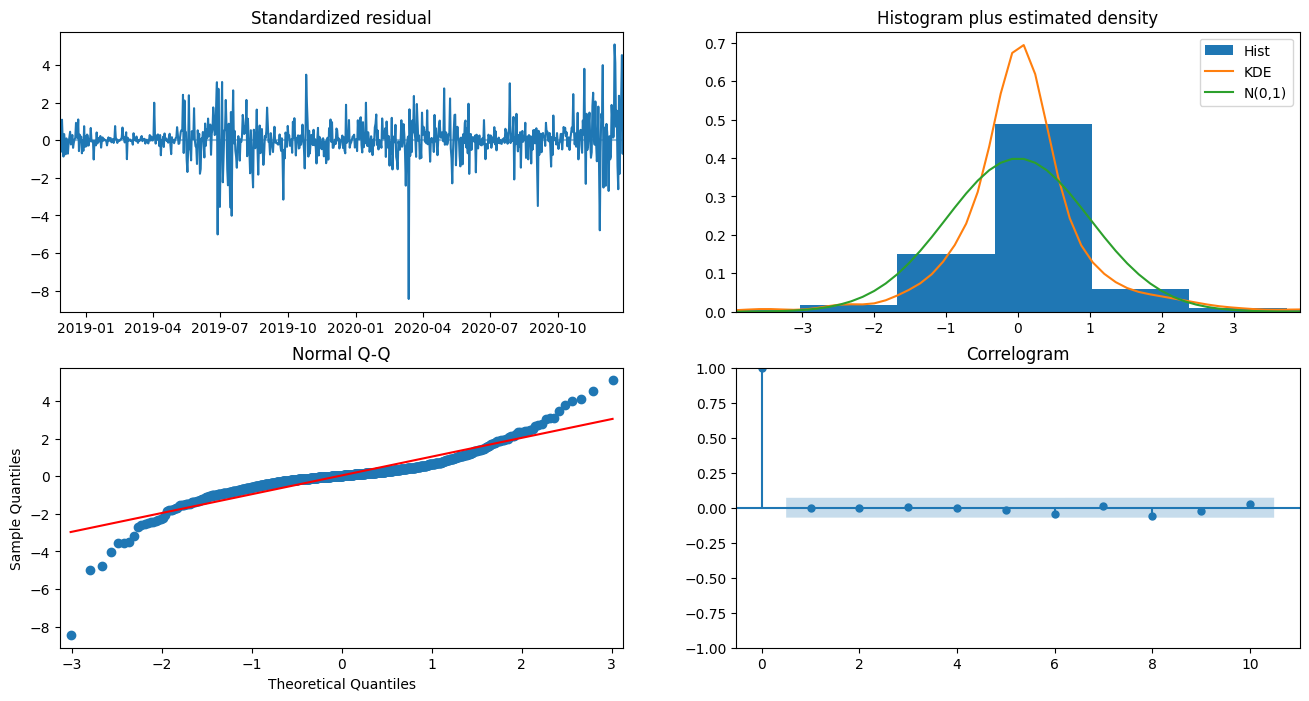

In [23]:
arima_model.fit(train_data)
arima_model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [24]:
model_pred = arima_model.predict(periods = len(test_data))

In [25]:
def forecast_one(data):
  fc, conf = arima_model.predict(n_periods = 1, return_conf_int = True)
  return_fc = fc.tolist()[0]
  return_conf =  np.asarray(conf).tolist()[0]

  return (return_fc, return_conf)

In [26]:
prediction = []
lower_interval = []
upper_interval = []

for new_data in test_data:
  fc, conf = forecast_one(new_data)
  prediction.append(fc)
  lower_interval.append(conf[0])
  upper_interval.append(conf[1])

  arima_model.update(new_data)

'\ndef maep(pred, val):\n\n  result = np.mean(np.abs((val-pred)/val))*100\n  return f"MAPE : {result:.2}"\n\nmaep(data["real"], data[0]) # 3.2\n'

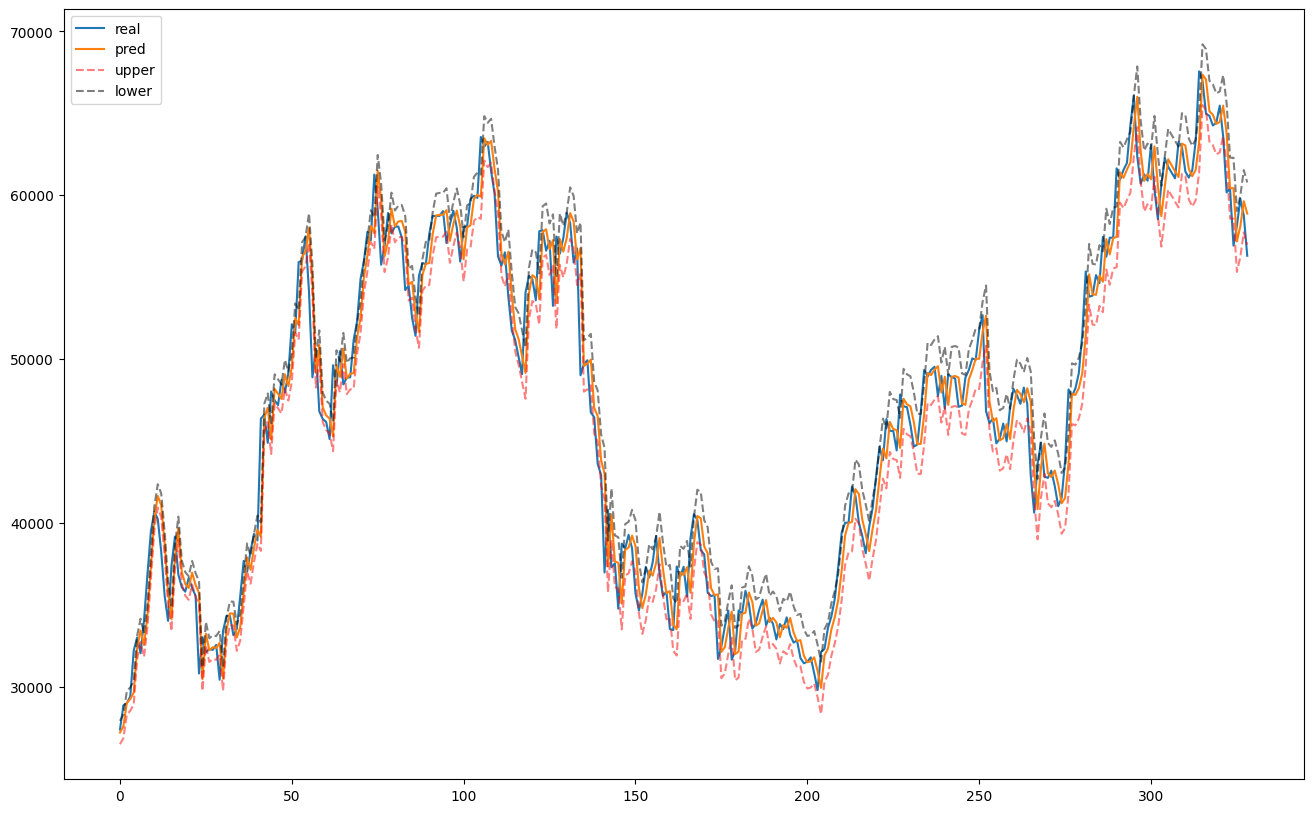

In [27]:
plt.figure(figsize=(16,10))
plt.plot(test_data.values, label = "real")
plt.plot(prediction, label = "pred")
plt.plot(lower_interval, "r--", alpha=0.5, label = "upper" )
plt.plot(upper_interval, "k--", alpha=0.5, label = "lower")
plt.legend()

data = pd.DataFrame(prediction, test_data).reset_index()

# mape:
'''
def maep(pred, val):

  result = np.mean(np.abs((val-pred)/val))*100
  return f"MAPE : {result:.2}"

maep(data["real"], data[0]) # 3.2
'''

# Prophet

In [28]:
from prophet import Prophet

In [29]:
model = Prophet(growth="linear", weekly_seasonality=True)
df2 = df["pred"].reset_index()

In [30]:
df2.rename(columns = {
    "Timestamp" : "ds",
    "pred" : "y"
}, inplace=True) # 값을 설정해줘야 함 (ds, y)

In [31]:
split = int(len(df2)*0.7)

train_data = df2[:split]
test_data = df2[split:]

In [32]:
model.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvvgogub/udjxrwyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvvgogub/1yl91v46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45711', 'data', 'file=/tmp/tmpkvvgogub/udjxrwyo.json', 'init=/tmp/tmpkvvgogub/1yl91v46.json', 'output', 'file=/tmp/tmpkvvgogub/prophet_model6acn_8_j/prophet_model-20240822090636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:06:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


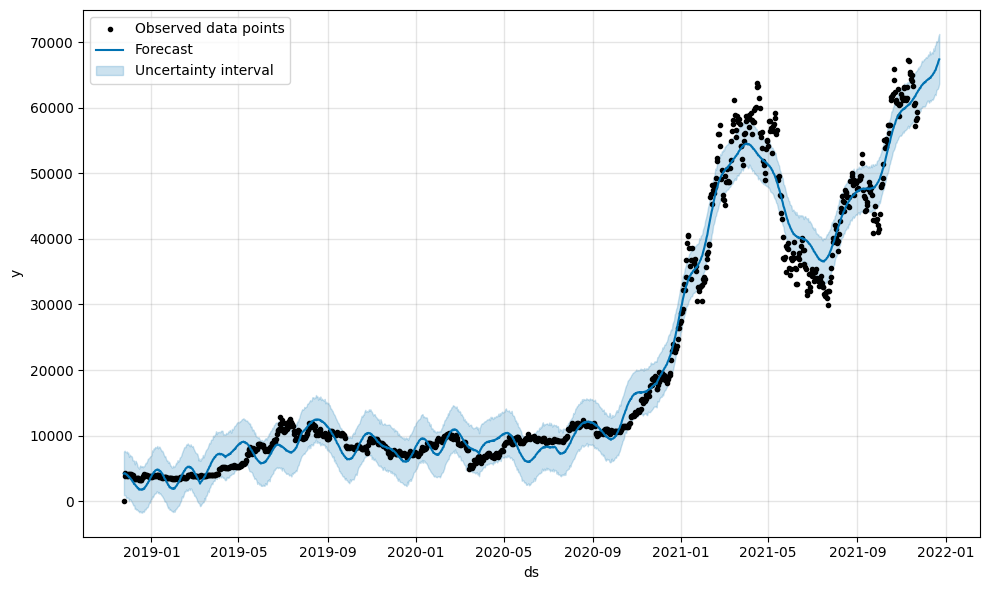

In [33]:
future = model.make_future_dataframe(periods=30)
pred = model.predict(future)
model.plot(pred, uncertainty=True)
plt.legend()
plt.show()

In [34]:
s= pd.concat((pred["trend"], df2["y"]), axis=1)
s.dropna(inplace=True)

In [35]:
#
mape(s["trend"], s["y"]) # 189.54 -> 성능이 너무 안좋음 : 이때 불확실성을 추가하면 좋은 값이 나올것으로 예상

189.54

# AI

In [36]:
# 간단한 LSTM을 생성하자 - 종가만 가지고 데이터 예측이 힘듦 -
df3 = pd.read_csv("/content/비트코인 과거 데이터 (2).csv")
df3=df3.sort_values("날짜")

In [37]:
# 거래량 : k이면 - 1000 / m :1,000,000
sample = []

for i in range(len(df3.values)):
  if df3["거래량"].loc[i].endswith("K")==True:
    sample.append(float(df3["거래량"].loc[i].split("K")[0])*1000)

  elif df3["거래량"].loc[i].endswith("B")==True:
    sample.append(float(df3["거래량"].loc[i].split("B")[0])*1000000)

  else:
    sample.append(float(df3["거래량"].loc[i].split("M")[0])*1000000000)

In [38]:
df3["거래량1"] = sample

In [39]:
df3_1 = df3[["날짜",	"종가",	"시가",	"고가"	,"저가",	"거래량1"]]

In [40]:
df3_1.set_index("날짜", inplace=True)

In [41]:
df3_1 = df3_1.iloc[:,0:].replace("," , "",regex=True).astype(float)

In [42]:
from sklearn.preprocessing import MinMaxScaler
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

#

df3_1[["종가","시가",	"고가"	,"저가",	"거래량1"]] = sc_x.fit_transform(df3_1)

#
ex=df3_1.reset_index()
ex["날짜"]=ex["날짜"].replace(" ","", regex=True)
ex["날짜"] = pd.to_datetime(ex["날짜"], format= "%Y-%m-%d")

ex.set_index("날짜", inplace=True)

In [43]:
ex

,종가,시가,고가,저가,거래량1
날짜,,,,,
2021-01-01,0.237104,0.229972,0.232354,0.236561,1.363238e-07
2021-01-02,0.286561,0.237093,0.295110,0.241855,1.209420e-07
2021-01-03,0.299924,0.286547,0.321602,0.295973,9.233038e-08
2021-01-04,0.283581,0.300925,0.301270,0.227465,6.499389e-08
2021-01-05,0.317948,0.283449,0.315665,0.259810,4.059295e-08
...,...,...,...,...,...
2024-08-18,0.744808,0.762938,0.764652,0.768918,2.681446e-07
2024-08-19,0.762692,0.744792,0.753901,0.758814,3.387307e-07
2024-08-20,0.754574,0.762675,0.784060,0.772068,2.058206e-07


In [44]:
# 데이터 split -> train - target(종가) 생성
x=ex.drop("종가", axis=1)
y=ex["종가"]

In [45]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [46]:
def sequence_data(x, y, window_size):
    input_data = []
    target_data = []

    for i in range(len(x) - window_size):
        input_data.append(np.array(x[i:i+window_size]))
        target_data.append(np.array(y[i+window_size]))

    return np.array(input_data), np.array(target_data)

In [47]:
x1,y1=sequence_data(x,y, window_size=20)

In [48]:
split

767

In [49]:
train_x1 = x1[:split]
train_y1 = y1[:split]

test_x1 = x1[split:]
test_y1 = y1[split:]

In [50]:
print(f"{train_x1[0]}  ---> { train_y1[0]}")

[[2.29971670e-01 2.32353571e-01 2.36561104e-01 1.36323787e-07]
 [2.37093320e-01 2.95110352e-01 2.41855350e-01 1.20942033e-07]
 [2.86546890e-01 3.21602400e-01 2.95972719e-01 9.23303757e-08]
 [3.00924593e-01 3.01270484e-01 2.27464529e-01 6.49938898e-08]
 [2.83448624e-01 3.15665007e-01 2.59810295e-01 4.05929547e-08]
 [3.18077643e-01 3.59518535e-01 3.20665470e-01 2.42415387e-08]
 [3.66937743e-01 4.18789795e-01 3.73552411e-01 8.46793476e-08]
 [4.13505998e-01 4.46298091e-01 3.78069355e-01 1.07871527e-07]
 [4.33418688e-01 4.36584572e-01 4.16785769e-01 8.57154243e-08]
 [4.25433015e-01 4.36565431e-01 3.51709167e-01 8.32314968e-08]
 [3.91318919e-01 3.81834223e-01 2.66994065e-01 1.05002391e-07]
 [3.42980724e-01 3.53669890e-01 3.05699732e-01 5.41947824e-08]
 [3.19158109e-01 3.73958303e-01 3.03536184e-01 3.00860741e-08]
 [3.77147186e-01 4.13802524e-01 3.80911699e-01 9.20381489e-08]
 [4.08431823e-01 4.07898194e-01 3.40015618e-01 1.45462515e-07]
 [3.66122594e-01 3.76866094e-01 3.56487601e-01 1.252058

In [51]:
#1. tensor로 지정
train_x = torch.tensor(train_x1, dtype = torch.float32)
train_y = torch.tensor(train_y1, dtype = torch.float32)
test_x = torch.tensor(test_x1, dtype = torch.float32)
test_y = torch.tensor(test_y1, dtype = torch.float32)

# 2. dataset
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# 3. dataloader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle= False)

In [52]:
train_x.size()

torch.Size([767, 20, 4])

In [53]:
e,w = next(iter(train_loader))
print(e.size())

print(w.size())
#
len(train_loader.dataset)
len(test_loader.dataset)

torch.Size([16, 20, 4])
torch.Size([16])


543

In [54]:
import torch
import torch.nn as nn

class simpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(simpleLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.tanh = nn.Tanh()

    def reset_h0_c0(self, batch_size):
        # h0와 c0를 초기화합니다. 각각 (num_layers, batch_size, hidden_size)의 크기를 가져야 합니다.
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return h0, c0

    def forward(self, x):
        # 배치 크기 추출
        batch_size = x.size(0)

        # 초기 hidden state와 cell state 초기화
        h0, c0 = self.reset_h0_c0(batch_size)

        # LSTM 통과
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)

        # LSTM 출력의 마지막 타임스텝의 출력 선택
        last_time_step_out = lstm_out[:, -1, :]

        # 최종 출력 계산 (선형 레이어 + Tanh)
        out = self.tanh(last_time_step_out)
        out = self.fc(last_time_step_out)

        return out

In [55]:
from torch.optim import Adam

model = simpleLSTM(4, 4, 4, 1) #(self, input_size, hi|den_size, num_layer, output_size)
loss = nn.MSELoss()
opimizer = Adam(model.parameters(), lr = 1e-4)

In [56]:
len(train_loader.dataset)

767

In [57]:
def train_loop(model, train_loader, loss_fn, optimizer):
    model.train()
    size = len(train_loader.dataset)
    total_loss = 0  # 에포크 당 총 손실을 추적
    batch_loss = []
    for batch, (input, target) in enumerate(train_loader):
        # 모델 예측
        pred = model(input)

        # 손실 계산
        loss = loss_fn(pred, target)

        # backpropagation
        optimizer.zero_grad()  # 이전 단계의 기울기를 초기화
        loss.backward()  # 기울기 계산
        optimizer.step()  # 가중치 갱신

        total_loss += loss.item()  # 손실 누적

        if batch % 30 == 0:
            current = batch * len(input)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(f"평균 손실 : {np.round(total_loss / len(train_loader),4)}")
    return total_loss / len(train_loader)  # 평균 손실 반환

In [58]:
def test_loop(model, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss = 0
    predictions = []
    targets = []

    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():  # 기울기 계산 비활성화
        for input, target in test_loader:
            # 모델 예측
            pred = model(input)

            # 손실 계산
            loss = loss_fn(pred, target)
            test_loss += loss.item()

            # 예측값과 실제값 저장
            predictions.append(pred)
            targets.append(target)

    # 평균 손실 계산
    test_loss /= num_batches

    # 예측값과 실제값을 텐서로 결합
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    print(f"Test Error(평균 손실): {test_loss:.4f}")

    return predictions, targets, test_loss

In [59]:
def test_loop(model, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss = 0
    predictions = []
    targets = []

    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():  # 기울기 계산 비활성화
        for input, target in test_loader:
            # 모델 예측
            pred = model(input)

            # 손실 계산
            loss = loss_fn(pred, target)
            test_loss += loss.item()

            # 예측값과 실제값 저장
            predictions.append(pred)
            targets.append(target)

    # 평균 손실 계산
    test_loss /= num_batches

    # 예측값과 실제값을 텐서로 결합
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    print(f"Test Error(평균 손실): {test_loss:.4f}")

    return predictions, targets, test_loss

In [60]:
for i in range(30):
  print(f"epochs:{i+1}")
  print("==========================")
  train_loop(model, train_loader, loss, opimizer)
  predictions, targets, test_loss = test_loop(model, test_loader, loss)
  print("==========================\n")

epochs:1
loss: 0.043602  [    0/  767]
loss: 0.058808  [  480/  767]
평균 손실 : 0.0676
Test Error(평균 손실): 0.0847

epochs:2
loss: 0.060575  [    0/  767]
loss: 0.059316  [  480/  767]
평균 손실 : 0.0649
Test Error(평균 손실): 0.0869

epochs:3
loss: 0.070739  [    0/  767]
loss: 0.052211  [  480/  767]
평균 손실 : 0.0634
Test Error(평균 손실): 0.0889

epochs:4
loss: 0.059098  [    0/  767]
loss: 0.041611  [  480/  767]
평균 손실 : 0.0627
Test Error(평균 손실): 0.0904

epochs:5
loss: 0.053286  [    0/  767]
loss: 0.053249  [  480/  767]
평균 손실 : 0.0624
Test Error(평균 손실): 0.0914

epochs:6
loss: 0.039303  [    0/  767]
loss: 0.070468  [  480/  767]
평균 손실 : 0.062
Test Error(평균 손실): 0.0925

epochs:7
loss: 0.055995  [    0/  767]
loss: 0.082559  [  480/  767]
평균 손실 : 0.0623
Test Error(평균 손실): 0.0933

epochs:8
loss: 0.060449  [    0/  767]
loss: 0.053333  [  480/  767]
평균 손실 : 0.0621
Test Error(평균 손실): 0.0937

epochs:9
loss: 0.058674  [    0/  767]
loss: 0.053270  [  480/  767]
평균 손실 : 0.0622
Test Error(평균 손실): 0.0942

ep

Text(0.5, 1.0, 'target')

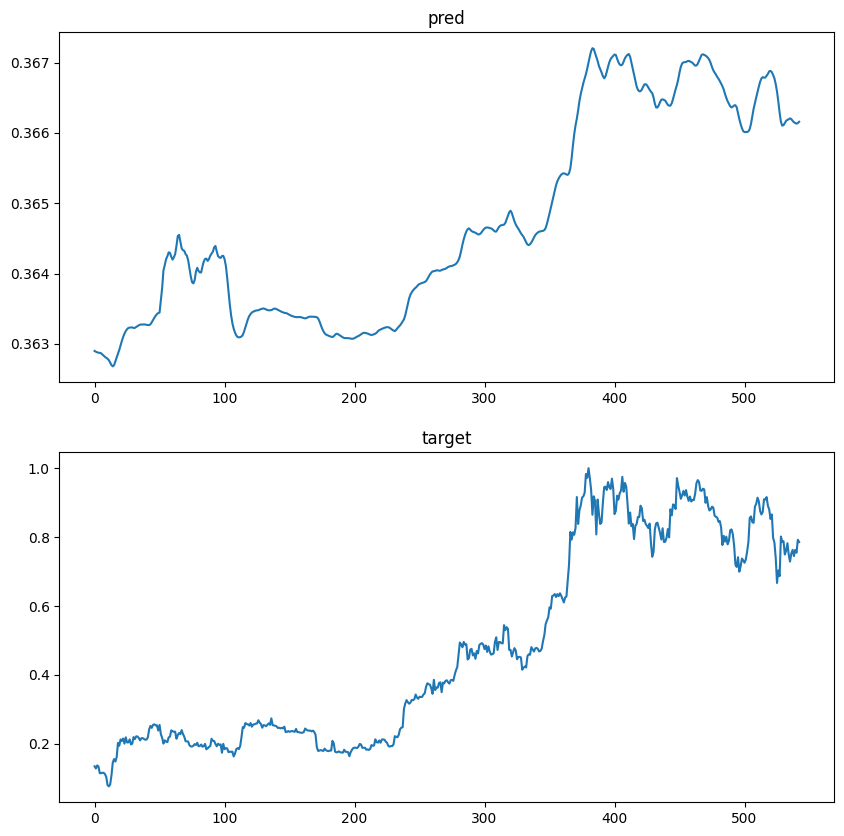

In [61]:
#
fig, axs  = plt.subplots(2,1, figsize=(10,10))
axs[0].plot(predictions.detach().numpy())
axs[0].set_title("pred")

axs[1].plot(targets.detach().numpy())
axs[1].set_title("target")

# 추세는 같으나, 단위를 조정하는 문제 발생...[과적합 됨 / train-test set의 값이 많이 다름] - 데이터가 작아 GPU는 사용하지 않음.
# 너무 두드려서 모델 상태가 좋지 않음